### Main 3 blocks

In [5]:
import os

import pandas as pd


def main() -> None:
    """
    Initial dataset pre-processing for the CBIS-DDSM dataset:
        * Retrieves the path of all images and filters out the cropped images.
        * Imports original CSV files with the full image information (patient_id, left or right breast, pathology,
        image file path, etc.).
        * Filters out the cases with more than one pathology in the original csv files.
        * Merges image path which extracted on GPU machine and image pathology which is in the original csv file on image id
        * Outputs 4 CSV files.

    Generate CSV file columns:
      img: image id (e.g Calc-Test_P_00038_LEFT_CC => <case type>_<patient id>_<left or right breast>_<CC or MLO>)
      img_path: image path on the GPU machine
      label: image pathology (BENIGN or MALIGNANT)
    
    Originally written as a group for the common pipeline. Later ammended by Adam Jaamour.
    
    :return: None
    """
    csv_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142'               # original csv folder (change as needed)
    img_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM'     # dataset folder (change as needed)
    csv_output_path = 'D:/Plaksha/data/CBIS-DDSM/all_info'                                           # csv output folder (change as needed)
    os.makedirs(csv_output_path, exist_ok=True)

    
    folders = os.listdir(img_root)

    cases_dict = dict()  # save image id and path

    for f in folders:
        if f.endswith('_CC') or f.endswith('_MLO'):  # filter out the cropped images
            path = list()

            for root, dirs, files in os.walk(img_root + '/' + f):  # retrieve the path of image
                for d in dirs:
                    path.append(d)
                for filename in files:
                    path.append(filename)

            img_path = img_root + '/' + f + '/' + '/'.join(path)  # generate image path
            print(f)
            print(img_path)
            cases_dict[f] = img_path

    df = pd.DataFrame(list(cases_dict.items()), columns=['img', 'img_path'])  # transform image dictionary to dataframe
    print(df)

    # image type and csv file name mapping
    type_dict = {'Calc-Test': 'calc_case_description_test_set.csv',
                 'Calc-Training': 'calc_case_description_train_set.csv',
                 'Mass-Test': 'mass_case_description_test_set.csv',
                 'Mass-Training': 'mass_case_description_train_set.csv'}

    for t in type_dict.keys():  # handle images based on the type
        df_subset = df[df['img'].str.startswith(t)]

        df_csv = pd.read_csv(csv_root + '/' + type_dict[t],
                             usecols=['pathology', 'image file path', 'breast density', 'assessment', 'subtlety'])  # read original csv file
        df_csv['img'] = df_csv.apply(lambda row: row['image file path'].split('/')[0],
                                     axis=1)  # extract image id from the path
        df_csv['pathology'] = df_csv.apply(
            lambda row: 'BENIGN' if row['pathology'] == 'BENIGN_WITHOUT_CALLBACK' else row['pathology'],
            axis=1)  # replace pathology 'BENIGN_WITHOUT_CALLBACK' to 'BENIGN'

        df_cnt = pd.DataFrame(
            df_csv.groupby(['img'])['pathology'].nunique()).reset_index()  # count dictict pathology for each image id
        df_csv = df_csv[~df_csv['img'].isin(
            list(df_cnt[df_cnt['pathology'] != 1]['img']))]  # filter out the image with more than one pathology
        df_csv = df_csv.drop(columns=['image file path'])
        df_csv = df_csv.drop_duplicates(
            keep='first')  # remove duplicate data (because original csv list all abnormality area, that make one image id may have more than one record)

        df_subset_new = pd.merge(df_subset, df_csv, how='inner',
                                 on='img')  # merge image path and image pathology on image id
        df_subset_new = df_subset_new.rename(columns={'pathology': 'label'})  # rename column 'pathology' to 'label'
        df_subset_new.to_csv(csv_output_path + '/' + t.lower() + '.csv',
                             index=False)  # output merged dataframe in csv format

        print(t)
        print('data_cnt: %d' % len(df_subset_new))
        print('multi pathology case:')
        print(list(df_cnt[df_cnt['pathology'] != 1]['img']))
        print()
        

    print('Finished pre-processing CSV for the CBIS-DDSM dataset.')


if __name__ == '__main__':
    main()

# ----------------------------------

# Calc-Test
# data_cnt: 282
# multi pathology case:
# ['Calc-Test_P_00353_LEFT_CC', 'Calc-Test_P_00353_LEFT_MLO']

# Calc-Training
# data_cnt: 1220
# multi pathology case:
# ['Calc-Training_P_00600_LEFT_CC', 'Calc-Training_P_00600_LEFT_MLO', 'Calc-Training_P_00937_RIGHT_CC', 'Calc-Training_P_00937_RIGHT_MLO', 'Calc-Training_P_01284_RIGHT_MLO', 'Calc-Training_P_01819_LEFT_CC', 'Calc-Training_P_01819_LEFT_MLO']

# Mass-Test
# data_cnt: 359
# multi pathology case:
# ['Mass-Test_P_00969_LEFT_CC', 'Mass-Test_P_00969_LEFT_MLO']

# Mass-Training
# data_cnt: 1225
# multi pathology case:
# ['Mass-Training_P_00419_LEFT_CC', 'Mass-Training_P_00419_LEFT_MLO', 'Mass-Training_P_00797_LEFT_CC', 'Mass-Training_P_00797_LEFT_MLO', 'Mass-Training_P_01103_RIGHT_CC', 'Mass-Training_P_01103_RIGHT_MLO']

Calc-Test_P_00038_LEFT_CC
D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_00038_LEFT_CC/08-29-2017-DDSM-NA-96009/1.000000-full mammogram images-63992/1-1.dcm
Calc-Test_P_00038_LEFT_MLO
D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO/08-29-2017-DDSM-NA-17613/1.000000-full mammogram images-97934/1-1.dcm
Calc-Test_P_00038_RIGHT_CC
D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_00038_RIGHT_CC/08-29-2017-DDSM-NA-28468/1.000000-full mammogram images-63304/1-1.dcm
Calc-Test_P_00038_RIGHT_MLO
D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_00038_RIGHT_MLO/08-29-2017-DDSM-NA-85215/1.000000-full mammogram images-08846/1-1.dcm
Calc-Test_P_00041_LEFT_CC
D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_00041_LEFT_CC/08-29-2017-DDSM-NA-52275/1.000000-full mammogram images-92812/1-1.dcm
Calc-Test_P_00041_LEFT_MLO
D:/Plaksha/CBIS

In [6]:
import os

import pandas as pd
from pathlib import Path


def main() -> None:
    """
    Initial dataset pre-processing for the CBIS-DDSM dataset:
        * Retrieves the path of all images and filters out the cropped images.
        * Imports original CSV files with the full image information (patient_id, left or right breast, pathology,
        image file path, etc.).
        * Filters out the cases with more than one pathology in the original csv files.
        * Merges image path which extracted on GPU machine and image pathology which is in the original csv file on image id
        * Outputs 4 CSV files.

    Generate CSV file columns:
      img: image id (e.g Calc-Test_P_00038_LEFT_CC => <case type>_<patient id>_<left or right breast>_<CC or MLO>)
      img_path: image path on the GPU machine
      label: image pathology (BENIGN or MALIGNANT)
      
    Originally written as a group for the common pipeline. Later ammended by Adam Jaamour.
    
    :return: None
    """
    csv_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142'               # original csv folder (change as needed)
    img_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM'     # dataset folder (change as needed)
    csv_output_path = 'D:/Plaksha/data/CBIS-DDSM-MASK/all_info'                                      # csv output folder (change as needed)
    os.makedirs(csv_output_path, exist_ok = True)
    folders = os.listdir(img_root)

    cases_dict = dict()  # save image id and path

    for f in folders:
        if f[-1].isdigit():  # get cropped image
            path = list()

            for root, dirs, files in os.walk(img_root + '/' + f):  # retrieve the path of image
                if len(dirs)>1:
                    pass
                else:
                    for d in dirs:
                        path.append(d)
                    for filename in files:
                        if filename.endswith('2.dcm'):
                            path.append(filename)

            img_path = img_root + '/' + f + '/' + '/'.join(path)  # generate image path
            cases_dict[f] = img_path

    df = pd.DataFrame(list(cases_dict.items()), columns=['img', 'img_path'])  # transform image dictionary to dataframe

    # image type and csv file name mapping
    type_dict = {'Calc-Test': 'calc_case_description_test_set.csv',
                 'Calc-Training': 'calc_case_description_train_set.csv',
                 'Mass-Test': 'mass_case_description_test_set.csv',
                 'Mass-Training': 'mass_case_description_train_set.csv'}

    for t in type_dict.keys():  # handle images based on the type
        df_subset = df[df['img'].str.startswith(t)]

        df_csv = pd.read_csv(csv_root + '/' + type_dict[t],
                             usecols=['pathology', 'ROI mask file path', 'breast density', 'assessment', 'subtlety'])  # read original csv file
        df_csv['img'] = df_csv.apply(lambda row: row['ROI mask file path'].split('/')[0],
                                     axis=1)  # extract image id from the path
        df_csv['pathology'] = df_csv.apply(
            lambda row: 'BENIGN' if row['pathology'] == 'BENIGN_WITHOUT_CALLBACK' else row['pathology'],
            axis=1)  # replace pathology 'BENIGN_WITHOUT_CALLBACK' to 'BENIGN'

        df_cnt = pd.DataFrame(
            df_csv.groupby(['img'])['pathology'].nunique()).reset_index()  # count dictict pathology for each image id
        df_csv = df_csv[~df_csv['img'].isin(
            list(df_cnt[df_cnt['pathology'] != 1]['img']))]  # filter out the image with more than one pathology
        df_csv = df_csv.drop(columns=['ROI mask file path'])
        df_csv = df_csv.drop_duplicates(
            keep='first')  # remove duplicate data (because original csv list all abnormality area, that make one image id may have more than one record)

        df_subset_new = pd.merge(df_subset, df_csv, how='inner',
                                 on='img')  # merge image path and image pathology on image id
        df_subset_new = df_subset_new.rename(columns={'pathology': 'label'})  # rename column 'pathology' to 'label'
        
        df_subset_new["correct_path"] = df_subset_new.apply(lambda x: 1 if x["img_path"].endswith('.dcm') else 0, axis=1)
        df_subset_new = df_subset_new[df_subset_new["correct_path"] == 1]
        df_subset_new.drop("correct_path",axis=1, inplace=True)
        
        df_subset_new.to_csv(csv_output_path + '/' + t.lower() + '.csv',
                             index=False)  # output merged dataframe in csv format

        print(t)
        print('data_cnt: %d' % len(df_subset_new))
        print('multi pathology case:')
        print(list(df_cnt[df_cnt['pathology'] != 1]['img']))
        print()

    print('Finished pre-processing CSV for the CBIS-DDSM dataset.')


if __name__ == '__main__':
    main()

# ----------------------------------

# Calc-Test
# data_cnt: 282
# multi pathology case:
# ['Calc-Test_P_00353_LEFT_CC', 'Calc-Test_P_00353_LEFT_MLO']

# Calc-Training
# data_cnt: 1220
# multi pathology case:
# ['Calc-Training_P_00600_LEFT_CC', 'Calc-Training_P_00600_LEFT_MLO', 'Calc-Training_P_00937_RIGHT_CC', 'Calc-Training_P_00937_RIGHT_MLO', 'Calc-Training_P_01284_RIGHT_MLO', 'Calc-Training_P_01819_LEFT_CC', 'Calc-Training_P_01819_LEFT_MLO']

# Mass-Test
# data_cnt: 359
# multi pathology case:
# ['Mass-Test_P_00969_LEFT_CC', 'Mass-Test_P_00969_LEFT_MLO']

# Mass-Training
# data_cnt: 1225
# multi pathology case:
# ['Mass-Training_P_00419_LEFT_CC', 'Mass-Training_P_00419_LEFT_MLO', 'Mass-Training_P_00797_LEFT_CC', 'Mass-Training_P_00797_LEFT_MLO', 'Mass-Training_P_01103_RIGHT_CC', 'Mass-Training_P_01103_RIGHT_MLO']

Calc-Test
data_cnt: 326
multi pathology case:
[]

Calc-Training
data_cnt: 1545
multi pathology case:
[]

Mass-Test
data_cnt: 367
multi pathology case:
[]

Mass-Training
data_cnt: 1226
multi pathology case:
[]

Finished pre-processing CSV for the CBIS-DDSM dataset.


In [7]:
import os

import pandas as pd
from pathlib import Path


def main() -> None:
    """
    Initial dataset pre-processing for the CBIS-DDSM dataset:
        * Retrieves the path of all images and filters out the cropped images.
        * Imports original CSV files with the full image information (patient_id, left or right breast, pathology,
        image file path, etc.).
        * Filters out the cases with more than one pathology in the original csv files.
        * Merges image path which extracted on GPU machine and image pathology which is in the original csv file on image id
        * Outputs 4 CSV files.

    Generate CSV file columns:
      img: image id (e.g Calc-Test_P_00038_LEFT_CC => <case type>_<patient id>_<left or right breast>_<CC or MLO>)
      img_path: image path on the GPU machine
      label: image pathology (BENIGN or MALIGNANT)
      
    Originally written as a group for the common pipeline. Later ammended by Adam Jaamour.
    
    :return: None
    """
    csv_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142'               # original csv folder (change as needed)
    img_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM'     # dataset folder (change as needed)
    csv_output_path = 'D:/Plaksha/data/CBIS-DDSM-CROPPED/all_info'                                      # csv output folder (change as needed)
    os.makedirs(csv_output_path, exist_ok = True)
    

    folders = os.listdir(img_root)

    cases_dict = dict()  # save image id and path

    for f in folders:
        if f[-1].isdigit():  # get cropped image
            path = list()

            for root, dirs, files in os.walk(img_root + '/' + f):  # retrieve the path of image
                if len(dirs)>1:
                    pass
                else:
                    for d in dirs:
                        path.append(d)
                    for filename in files:
                        if filename.endswith('1.dcm'):
                            path.append(filename)

            img_path = img_root + '/' + f + '/' + '/'.join(path)  # generate image path
            cases_dict[f] = img_path

    df = pd.DataFrame(list(cases_dict.items()), columns=['img', 'img_path'])  # transform image dictionary to dataframe

    # image type and csv file name mapping
    type_dict = {'Calc-Test': 'calc_case_description_test_set.csv',
                 'Calc-Training': 'calc_case_description_train_set.csv',
                 'Mass-Test': 'mass_case_description_test_set.csv',
                 'Mass-Training': 'mass_case_description_train_set.csv'}

    for t in type_dict.keys():  # handle images based on the type
        df_subset = df[df['img'].str.startswith(t)]

        df_csv = pd.read_csv(csv_root + '/' + type_dict[t],
                             usecols=['pathology', 'ROI mask file path', 'breast density', 'assessment', 'subtlety'])  # read original csv file
        df_csv['img'] = df_csv.apply(lambda row: row['ROI mask file path'].split('/')[0],
                                     axis=1)  # extract image id from the path
        df_csv['pathology'] = df_csv.apply(
            lambda row: 'BENIGN' if row['pathology'] == 'BENIGN_WITHOUT_CALLBACK' else row['pathology'],
            axis=1)  # replace pathology 'BENIGN_WITHOUT_CALLBACK' to 'BENIGN'

        df_cnt = pd.DataFrame(
            df_csv.groupby(['img'])['pathology'].nunique()).reset_index()  # count dictict pathology for each image id
        df_csv = df_csv[~df_csv['img'].isin(
            list(df_cnt[df_cnt['pathology'] != 1]['img']))]  # filter out the image with more than one pathology
        df_csv = df_csv.drop(columns=['ROI mask file path'])
        df_csv = df_csv.drop_duplicates(
            keep='first')  # remove duplicate data (because original csv list all abnormality area, that make one image id may have more than one record)

        df_subset_new = pd.merge(df_subset, df_csv, how='inner',
                                 on='img')  # merge image path and image pathology on image id
        df_subset_new = df_subset_new.rename(columns={'pathology': 'label'})  # rename column 'pathology' to 'label'
        
        df_subset_new["correct_path"] = df_subset_new.apply(lambda x: 1 if x["img_path"].endswith('.dcm') else 0, axis=1)
        df_subset_new = df_subset_new[df_subset_new["correct_path"] == 1]
        df_subset_new.drop("correct_path",axis=1, inplace=True)
        
        df_subset_new.to_csv(csv_output_path + '/' + t.lower() + '.csv',
                             index=False)  # output merged dataframe in csv format

        print(t)
        print('data_cnt: %d' % len(df_subset_new))
        print('multi pathology case:')
        print(list(df_cnt[df_cnt['pathology'] != 1]['img']))
        print()

    print('Finished pre-processing CSV for the CBIS-DDSM dataset.')


if __name__ == '__main__':
    main()

# ----------------------------------

# Calc-Test
# data_cnt: 282
# multi pathology case:
# ['Calc-Test_P_00353_LEFT_CC', 'Calc-Test_P_00353_LEFT_MLO']

# Calc-Training
# data_cnt: 1220
# multi pathology case:
# ['Calc-Training_P_00600_LEFT_CC', 'Calc-Training_P_00600_LEFT_MLO', 'Calc-Training_P_00937_RIGHT_CC', 'Calc-Training_P_00937_RIGHT_MLO', 'Calc-Training_P_01284_RIGHT_MLO', 'Calc-Training_P_01819_LEFT_CC', 'Calc-Training_P_01819_LEFT_MLO']

# Mass-Test
# data_cnt: 359
# multi pathology case:
# ['Mass-Test_P_00969_LEFT_CC', 'Mass-Test_P_00969_LEFT_MLO']

# Mass-Training
# data_cnt: 1225
# multi pathology case:
# ['Mass-Training_P_00419_LEFT_CC', 'Mass-Training_P_00419_LEFT_MLO', 'Mass-Training_P_00797_LEFT_CC', 'Mass-Training_P_00797_LEFT_MLO', 'Mass-Training_P_01103_RIGHT_CC', 'Mass-Training_P_01103_RIGHT_MLO']

Calc-Test
data_cnt: 326
multi pathology case:
[]

Calc-Training
data_cnt: 1546
multi pathology case:
[]

Mass-Test
data_cnt: 378
multi pathology case:
[]

Mass-Training
data_cnt: 1318
multi pathology case:
[]

Finished pre-processing CSV for the CBIS-DDSM dataset.


In [ ]:
import os

import pandas as pd
from pathlib import Path
import pydicom
from skimage.measure import label, regionprops
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np


def main() -> None:
    """
    Initial dataset pre-processing for the CBIS-DDSM dataset to generate the bounding box ground truth for images
    :return: None
    """
    csv_path = "../data/CBIS-DDSM-mask/final_mask_training.csv"
    as_df = pd.read_csv(csv_path)
    
    f = open("../data/CBIS-DDSM-mask/bbox_groud_truth.txt", "a")
    for i in range(as_df.shape[0]):
        string = as_df["img_path"][i]
        # Get bounding box
        minr, minc, maxr, maxc = get_bbox_of_mask(as_df["mask_img_path"][i])
        string += "," + str(minr)
        string += "," + str(minc)
        string += "," + str(maxr)
        string += "," + str(maxc)
        string += ",0"
        f.write("\n")
        f.write(string)

    f.close()


def get_bbox_of_mask(mask_path):
    # Process input ground truth mask and generate bounding box dimensions of tumours
    image_bytes = tf.io.read_file(mask_path)
    image = tfio.image.decode_dicom_image(image_bytes, color_dim = True,  dtype=tf.uint16)
    image = tf.image.resize_with_pad(image, 1024, 640)
    array = np.array(image)
    array = array[0,:,:,0].astype(int)
    regions = regionprops(array)
    region = regions[0]
    minr, minc, maxr, maxc = region.bbox
    return minr, minc, maxr, maxc


if __name__ == '__main__':
    main()

In [5]:
import os
import pandas as pd


In [100]:
csv_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142'               # original csv folder (change as needed)
img_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM'     # dataset folder (change as needed)
csv_output_path = 'D:/Plaksha/data/CBIS-DDSM/new/'                                           # csv output folder (change as needed)

folders = os.listdir(img_root)

cases_dict = dict()  # save image id and path

for f in folders:
    if f.endswith('_CC') or f.endswith('_MLO'):  # filter out the cropped images
        path = list()

        for root, dirs, files in os.walk(img_root + '/' + f):  # retrieve the path of image
            for d in dirs:
                path.append(d)
            for filename in files:
                path.append(filename)

        img_path = img_root + '/' + f + '/' + '/'.join(path)  # generate image path
        print(f)
        print(img_path)
        cases_dict[f] = img_path

df = pd.DataFrame(list(cases_dict.items()), columns=['img', 'img_path'])  # transform image dictionary to dataframe
print(df)
df.to_csv("D:/Plaksha/dfdfdf.csv")

# image type and csv file name mapping
type_dict = {'Calc-Test': 'calc_case_description_test_set.csv',
             'Calc-Training': 'calc_case_description_train_set.csv',
             'Mass-Test': 'mass_case_description_test_set.csv',
             'Mass-Training': 'mass_case_description_train_set.csv'}

for t in type_dict.keys():  # handle images based on the type
    df_subset = df[df['img'].str.startswith(t)]

    df_csv = pd.read_csv(csv_root + '/' + type_dict[t],
                         usecols=['pathology', 'image file path'])  # read original csv file
    df_csv['img'] = df_csv.apply(lambda row: row['image file path'].split('/')[0],
                                 axis=1)  # extract image id from the path
    df_csv['pathology'] = df_csv.apply(
        lambda row: 'BENIGN' if row['pathology'] == 'BENIGN_WITHOUT_CALLBACK' else row['pathology'],
        axis=1)  # replace pathology 'BENIGN_WITHOUT_CALLBACK' to 'BENIGN'

    df_cnt = pd.DataFrame(
        df_csv.groupby(['img'])['pathology'].nunique()).reset_index()  # count dictict pathology for each image id
    df_csv = df_csv[~df_csv['img'].isin(
        list(df_cnt[df_cnt['pathology'] != 1]['img']))]  # filter out the image with more than one pathology
    df_csv = df_csv.drop(columns=['image file path'])
    df_csv = df_csv.drop_duplicates(
        keep='first')  # remove duplicate data (because original csv list all abnormality area, that make one image id may have more than one record)

    df_subset_new = pd.merge(df_subset, df_csv, how='inner',
                             on='img')  # merge image path and image pathology on image id
    df_subset_new = df_subset_new.rename(columns={'pathology': 'label'})  # rename column 'pathology' to 'label'
    df_subset_new.to_csv(csv_output_path + '/' + t.lower() + '.csv',
                         index=False)  # output merged dataframe in csv format

    print(t)
    print('data_cnt: %d' % len(df_subset_new))
    print('multi pathology case:')
    print(list(df_cnt[df_cnt['pathology'] != 1]['img']))
    print()

print('Finished pre-processing CSV for the CBIS-DDSM dataset.')



Calc-Test_P_00038_LEFT_CC
D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_00038_LEFT_CC/08-29-2017-DDSM-NA-96009/1.000000-full mammogram images-63992/1-1.dcm
Calc-Test_P_00038_LEFT_MLO
D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO/08-29-2017-DDSM-NA-17613/1.000000-full mammogram images-97934/1-1.dcm
Calc-Test_P_00038_RIGHT_CC
D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_00038_RIGHT_CC/08-29-2017-DDSM-NA-28468/1.000000-full mammogram images-63304/1-1.dcm
Calc-Test_P_00038_RIGHT_MLO
D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_00038_RIGHT_MLO/08-29-2017-DDSM-NA-85215/1.000000-full mammogram images-08846/1-1.dcm
Calc-Test_P_00041_LEFT_CC
D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM/Calc-Test_P_00041_LEFT_CC/08-29-2017-DDSM-NA-52275/1.000000-full mammogram images-92812/1-1.dcm
Calc-Test_P_00041_LEFT_MLO
D:/Plaksha/CBIS

In [106]:
import os

import pandas as pd
from pathlib import Path


def main() -> None:
    """
    Initial dataset pre-processing for the CBIS-DDSM dataset:
        * Retrieves the path of all images and filters out the cropped images.
        * Imports original CSV files with the full image information (patient_id, left or right breast, pathology,
        image file path, etc.).
        * Filters out the cases with more than one pathology in the original csv files.
        * Merges image path which extracted on GPU machine and image pathology which is in the original csv file on image id
        * Outputs 4 CSV files.

    Generate CSV file columns:
      img: image id (e.g Calc-Test_P_00038_LEFT_CC => <case type>_<patient id>_<left or right breast>_<CC or MLO>)
      img_path: image path on the GPU machine
      label: image pathology (BENIGN or MALIGNANT)
      
    Originally written as a group for the common pipeline. Later ammended by Adam Jaamour.
    
    :return: None
    """

    csv_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142'               # original csv folder (change as needed)
    img_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM'     # dataset folder (change as needed)
    csv_output_path = 'D:/Plaksha/data/data'                                      # csv output folder (change as needed)
    
    if not os.path.exists(csv_output_path):
        os.mkdir(csv_output_path)
    
    folders = os.listdir(img_root)
    
    cases_dict = dict()  # save image id and path
    final_list = []
    for f in folders:
        if f[-1].isdigit():  # get cropped image
            path = list()
            #print(f)
    
            for root, dirs, files in os.walk(img_root + '/' + f):  # retrieve the path of image
                
                #print(dirs)
                if len(dirs)>1:
                    pass
                else:
                    for d in dirs:
                        path.append(d)
    
            img_path = img_root + '/' + f + '/' + '/'.join(path)
            #print(img_path)
    
            list_of_files = filter( os.path.isfile, glob.glob(img_path + '/*.dcm') ) 
    
            
      
            # Sort list of files in directory by size  
            list_of_files = sorted( list_of_files, 
                                    key =  lambda x: os.stat(x).st_size) 
    
            #file_size = os.path.getsize(list_of_files[0])
            #print(file_size)
    
            #print(list_of_files)
            id_list = [f]
            #print(id_list)
    
            combine_list = id_list + list_of_files
            #print(combine_list)
            final_list.append(combine_list)
            
         
            
            cases_dict[f] = img_path
    #print(final_list)
    dfdf = pd.DataFrame(final_list, columns =['img', 'crop_path', 'mask_path'])
    #df = pd.DataFrame(list(cases_dict.items()), columns=['img', 'img_path'])  # transform image dictionary to dataframe
    #print(df)
    dfdf.to_csv("D:/Plaksha/dfdf.csv")

    dfresult = dfdf.dropna()
    print(dfresult)



    # image type and csv file name mapping
    type_dict = {'Calc-Test': 'calc_case_description_test_set.csv',
                 'Calc-Training': 'calc_case_description_train_set.csv',
                 'Mass-Test': 'mass_case_description_test_set.csv',
                 'Mass-Training': 'mass_case_description_train_set.csv'}

    for t in type_dict.keys():  # handle images based on the type
        df_subset = dfresult[dfresult['img'].str.startswith(t)]

        df_csv = pd.read_csv(csv_root + '/' + type_dict[t],
                             usecols=['pathology', 'ROI mask file path'])  # read original csv file
        df_csv['img'] = df_csv.apply(lambda row: row['ROI mask file path'].split('/')[0],
                                     axis=1)  # extract image id from the path
        df_csv['pathology'] = df_csv.apply(
            lambda row: 'BENIGN' if row['pathology'] == 'BENIGN_WITHOUT_CALLBACK' else row['pathology'],
            axis=1)  # replace pathology 'BENIGN_WITHOUT_CALLBACK' to 'BENIGN'

        df_cnt = pd.DataFrame(
            df_csv.groupby(['img'])['pathology'].nunique()).reset_index()  # count dictict pathology for each image id
        df_csv = df_csv[~df_csv['img'].isin(
            list(df_cnt[df_cnt['pathology'] != 1]['img']))]  # filter out the image with more than one pathology
        df_csv = df_csv.drop(columns=['ROI mask file path'])
        df_csv = df_csv.drop_duplicates(
            keep='first')  # remove duplicate data (because original csv list all abnormality area, that make one image id may have more than one record)

        df_subset_new = pd.merge(df_subset, df_csv, how='inner',
                                 on='img')  # merge image path and image pathology on image id
        df_subset_new = df_subset_new.rename(columns={'pathology': 'label'})  # rename column 'pathology' to 'label'
        
        df_subset_new["correct_path"] = df_subset_new.apply(lambda x: 1 if x["crop_path"].endswith('.dcm') else 0, axis=1)
        df_subset_new = df_subset_new[df_subset_new["correct_path"] == 1]
        df_subset_new.drop("correct_path",axis=1, inplace=True)
        
        df_subset_new.to_csv(csv_output_path + '/' + t.lower() + '.csv',
                             index=False)  # output merged dataframe in csv format

        print(t)
        print('data_cnt: %d' % len(df_subset_new))
        print('multi pathology case:')
        print(list(df_cnt[df_cnt['pathology'] != 1]['img']))
        print()

    print('Finished pre-processing CSV for the CBIS-DDSM dataset.')


if __name__ == '__main__':
    main()



                                    img  \
0           Calc-Test_P_00038_LEFT_CC_1   
1          Calc-Test_P_00038_LEFT_MLO_1   
2          Calc-Test_P_00038_RIGHT_CC_1   
3          Calc-Test_P_00038_RIGHT_CC_2   
4         Calc-Test_P_00038_RIGHT_MLO_1   
...                                 ...   
3552  Mass-Training_P_01888_RIGHT_MLO_1   
3553   Mass-Training_P_01889_RIGHT_CC_1   
3554  Mass-Training_P_01889_RIGHT_MLO_1   
3555   Mass-Training_P_01890_LEFT_MLO_1   
3557   Mass-Training_P_01946_RIGHT_CC_1   

                                              crop_path  \
0     D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...   
1     D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...   
2     D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...   
3     D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...   
4     D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...   
...                                                 ...   
3552  D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...   
3553  D:/Pl

In [98]:

csv_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142'               # original csv folder (change as needed)
img_root = 'D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/CBIS-DDSM'     # dataset folder (change as needed)
csv_output_path = 'D:/Plaksha/data/CBIS-DDSM-CROPPED'                                      # csv output folder (change as needed)

if not os.path.exists(csv_output_path):
    os.mkdir(csv_output_path)

folders = os.listdir(img_root)

cases_dict = dict()  # save image id and path
final_list = []
for f in folders:
    if f[-1].isdigit():  # get cropped image
        path = list()
        print(f)

        for root, dirs, files in os.walk(img_root + '/' + f):  # retrieve the path of image
            
            #print(dirs)
            if len(dirs)>1:
                pass
            else:
                for d in dirs:
                    path.append(d)

        img_path = img_root + '/' + f + '/' + '/'.join(path)
        #print(img_path)

        list_of_files = filter( os.path.isfile, glob.glob(img_path + '/*.dcm') ) 

        
  
        # Sort list of files in directory by size  
        list_of_files = sorted( list_of_files, 
                                key =  lambda x: os.stat(x).st_size) 

        #file_size = os.path.getsize(list_of_files[0])
        #print(file_size)

        #print(list_of_files)
        id_list = [f]
        #print(id_list)

        combine_list = id_list + list_of_files
        #print(combine_list)
        final_list.append(combine_list)
        
     
        
        cases_dict[f] = img_path
#print(final_list)
dfdf = pd.DataFrame(final_list, columns =['ID', 'crop', 'mask'])
#df = pd.DataFrame(list(cases_dict.items()), columns=['img', 'img_path'])  # transform image dictionary to dataframe
#print(df)
dfdf.to_csv("D:/Plaksha/dfdf.csv")
'''# Iterate over sorted list of file names 
# and print them along with size one by one  
for path_of_file in list_of_files: 
    size_of_file  = os.stat(path_of_file).st_size  
    print(size_of_file, ' -->', path_of_file)''' 

        
            
            
        

"# Iterate over sorted list of file names \n# and print them along with size one by one  \nfor path_of_file in list_of_files: \n    size_of_file  = os.stat(path_of_file).st_size  \n    print(size_of_file, ' -->', path_of_file)"

In [86]:
                for filename in files:      
                    #print(path)
                    img_path = img_root + '/' + f + '/' + '/'.join(path) + '/' + filename
                    
                    print(img_path)
                    file_size = os.path.getsize(img_path)
                    print(file_size)
                                        
                    #print(f)
                    #print(path)

        #img_path = img_root + '/' + f + '/' + '/'.join(path)  # generate image path
        #cases_dict[f] = img_path

#df = pd.DataFrame(list(cases_dict.items()), columns=['img', 'img_path'])  # transform image dictionary to dataframe

D:/Plaksha/code_data_ddsm/Mass-Training_P_00023_RIGHT_MLO_1/07-21-2016-DDSM-NA-90295/1.000000-ROI mask images-44365/1-1.dcm
19720386
D:/Plaksha/code_data_ddsm/Mass-Training_P_00023_RIGHT_MLO_1/07-21-2016-DDSM-NA-90295/1.000000-ROI mask images-44365/1-2.dcm
132462


In [42]:
import glob 
import os 
  
name_of_dir = 'dir_path/'
  
# Storing list of all files (file paths) 
# in the given directory in list_of_files 
list_of_files = filter( os.path.isfile, 
                        glob.glob(name_of_dir + '*') ) 
  
# Sort list of files in directory by size  
list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat(x).st_size) 
  
# Iterate over sorted list of file names 
# and print them along with size one by one  
for path_of_file in list_of_files: 
    size_of_file  = os.stat(path_of_file).st_size  
    print(size_of_file, ' -->', path_of_file) 

In [167]:
load_csv = pd.read_csv("D:/plaksha/data/data/calc-test.csv")

In [168]:
load_csv

,img,crop_path,mask_path,label
0,Calc-Test_P_00038_LEFT_CC_1,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,BENIGN
1,Calc-Test_P_00038_LEFT_MLO_1,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,BENIGN
2,Calc-Test_P_00038_RIGHT_CC_1,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,BENIGN
3,Calc-Test_P_00038_RIGHT_CC_2,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,BENIGN
4,Calc-Test_P_00038_RIGHT_MLO_1,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,BENIGN
...,...,...,...,...
321,Calc-Test_P_02464_RIGHT_MLO_1,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,MALIGNANT
322,Calc-Test_P_02498_RIGHT_CC_1,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,BENIGN
323,Calc-Test_P_02498_RIGHT_MLO_1,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,BENIGN
324,Calc-Test_P_02501_RIGHT_CC_1,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,D:/Plaksha/CBIS-DDSM/manifest-ZkhPvrLo52167308...,MALIGNANT


In [187]:
a= load_csv["img"][0]

In [189]:
a[:-2]

'Calc-Test_P_00038_LEFT_CC'

In [107]:
import matplotlib.pyplot as plt
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]


In [109]:
# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


In [114]:
csvv = pd.read_csv('C:/Users/deepanshu.sharma/Downloads/find.csv')

In [130]:
csvv

,FPrate,Sensivity[Mean],Sensivity[Lower bound],Sensivity[Upper bound]
0,0.125000,0.718558,0.515152,0.9
1,0.125788,0.719077,0.515152,0.9
2,0.126575,0.719077,0.515152,0.9
3,0.127363,0.719077,0.515152,0.9
4,0.128150,0.719077,0.515152,0.9
...,...,...,...,...
9995,7.996850,0.931799,0.800000,1.0
9996,7.997637,0.931799,0.800000,1.0
9997,7.998425,0.931799,0.800000,1.0
9998,7.999212,0.931799,0.800000,1.0


In [132]:
df1new_list = csvv['FPrate'].tolist()

In [133]:
df2new_list = csvv['Sensivity[Mean]'].tolist()

In [134]:
df1new_list

[0.125,
 0.125787579,
 0.126575158,
 0.127362736,
 0.128150315,
 0.128937894,
 0.129725473,
 0.130513051,
 0.13130063,
 0.132088209,
 0.132875788,
 0.133663366,
 0.134450945,
 0.135238524,
 0.136026103,
 0.136813681,
 0.13760126,
 0.138388839,
 0.139176418,
 0.139963996,
 0.140751575,
 0.141539154,
 0.142326733,
 0.143114311,
 0.14390189,
 0.144689469,
 0.145477048,
 0.146264626,
 0.147052205,
 0.147839784,
 0.148627363,
 0.149414941,
 0.15020252,
 0.150990099,
 0.151777678,
 0.152565257,
 0.153352835,
 0.154140414,
 0.154927993,
 0.155715572,
 0.15650315,
 0.157290729,
 0.158078308,
 0.158865887,
 0.159653465,
 0.160441044,
 0.161228623,
 0.162016202,
 0.16280378,
 0.163591359,
 0.164378938,
 0.165166517,
 0.165954095,
 0.166741674,
 0.167529253,
 0.168316832,
 0.16910441,
 0.169891989,
 0.170679568,
 0.171467147,
 0.172254725,
 0.173042304,
 0.173829883,
 0.174617462,
 0.175405041,
 0.176192619,
 0.176980198,
 0.177767777,
 0.178555356,
 0.179342934,
 0.180130513,
 0.180918092,
 0.18

In [135]:
df2new_list

[0.71855849,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.719076991,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.726716757,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.736099482,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.74336648,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.750673413,
 0.7506

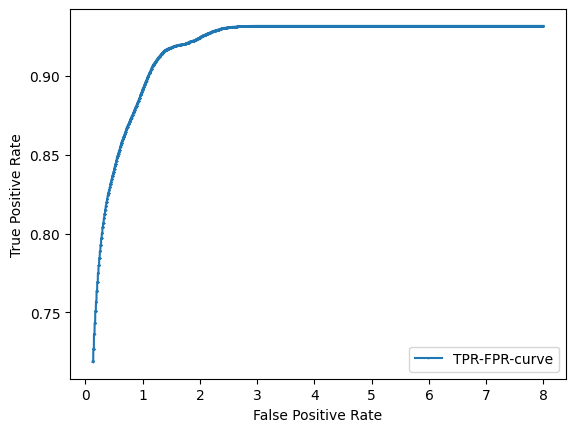

In [146]:
plt.plot(df1new_list, df2new_list, marker='.', label='TPR-FPR-curve',  markersize=0.5)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [162]:
import math
from itertools import pairwise
import scipy as sp

In [194]:
a = sp.integrate.trapezoid(df2new_list, df1new_list)

In [195]:
a

7.2366935009068065

In [196]:
total = 8-0.125


In [198]:
total

7.875

In [199]:
Area = a/total*100

In [200]:
Area


91.89452064643564